In [1]:
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy import linalg
from scipy.linalg import eigh
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import os

In [2]:
def spectrogram(path):
    data, sample_rate = librosa.load(path, sr = 16000) # Reading the file and decomposing into sample rate and amplitude vector
    
    # Defining Hamming window particulars
    window = 0.025
    shift = 0.01
    
    # Translating into number of samples from given Hamming window particulars
    frame_length, frame_step = int(window * sample_rate), int(shift * sample_rate)
    signal_length = len(data)

    # Calculating number of frames. Converting to inn tas the values are floats and the calculated values need to be discrete integers.
    num_frames = int((signal_length - frame_length) / frame_step)

    # Creating an envelope of array that shifts with Hamming window 
    envelope_length = num_frames * num_frames + frame_length

    # Storing data into a temporary array, to be used for appending
    temp = np.zeros((envelope_length - signal_length))
    envelope = np.append(data, temp) 

    # Using np.tile to create repeating arrays while using arange to set-up frame length and corresponding entries
    storage = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T

    # Storing the data into the frames
    frames = envelope[storage]
    
    point_FFT = 64

    fft_data = np.absolute(np.fft.fft(frames, point_FFT))  # Magnitude of the FFT
    
    fft_data = fft_data.T
    
    fft_data = fft_data[0:32,:] # Slicing into top 32 vectors 
    
    spectrogram = fft_data.T - np.mean(fft_data.T, axis=0)

    spectrogram = spectrogram.T
    
    spectrogram = np.abs(spectrogram)
    
    return np.log(spectrogram)

In [3]:
# Storing file names

names_speech = os.listdir('speech_music_classification/train/speech/')

names_music = os.listdir('speech_music_classification/train/music/')


# Creating the music data matrix
music_data = []

for name in names_music:
    music_data.append(spectrogram('speech_music_classification/train/music/'+name))

music_data = np.array(music_data)

music_data = music_data.reshape(music_data.shape[1], music_data.shape[2]*music_data.shape[0])
music_data = music_data.T


# Creating the speech data matrix
speech_data = []

for name in names_speech:
    speech_data.append(spectrogram('speech_music_classification/train/speech/'+name))

speech_data = np.array(speech_data)

speech_data = speech_data.reshape(speech_data.shape[1], speech_data.shape[2]*speech_data.shape[0])
speech_data = speech_data.T


In [4]:
combined_data = np.concatenate((speech_data,music_data), axis=0)

combined_data = combined_data[::3] # Subsampling

In [5]:
#### INITIAL DATA ####

pi = np.array([0.5,0.5,0.0])

A = np.array([[0.6,0.4,0.0],[0.3,0.5,0.2],[0.0, 0.1,0.9]])

B = np.array([[0.25,0.25,0.25,0.25,0.0,0.0,0.0,0.0], [0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125], [0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0]])

### FORWARD ALGORITHM

In [6]:
def forward(seq, A, B, pi):
    
    scaling = []
    
    alpha = np.zeros((seq.shape[0], A.shape[0]))
    alpha[0, :] = (pi * B[:, seq[0]])  
    
    p = alpha[0, :].sum()
    alpha[0,:] = alpha[0, :]/p  # Scaling the first row
    
    scaling.append(1/p)
    
    for t in range(1, seq.shape[0]):
        ss = 0
        for j in range(A.shape[0]):
            alpha[t, j] = (alpha[t - 1].dot(A[:, j]) * B[j, seq[t]])
            ss = ss + alpha[t, j]
        alpha[t,:] = alpha[t,:]/ss  # Scaling all the rows
        scaling.append(1/ss)
        
    return alpha, np.array(scaling)

### BACKWARD ALGORITHM

In [7]:
def backward(A,B,seq,sc):
    N = A.shape[1]
    T = seq.shape[0]
    beta = np.zeros((seq.shape[0], A.shape[0]))
    t = seq.shape[0]-1
    for i in range(0,N):
        beta[t][i] = sc[t]
    t=seq.shape[0] - 2
    
    while t>=0:
        for i in range(N):
            for j in range(N):
                beta[t][i] = beta[t][i] + (beta[t+1][j]*A[i][j]*B[j][seq[t+1]])
        for i in range(0,3):
            beta[t][i] = beta[t][i]*sc[t]
        t = t - 1
    return beta

#### Applying the algorithms to select data

In [8]:
# Shuffling the rows of combined data matrix in order to avoid bias while training of K-Means

np.take(combined_data,np.random.permutation(combined_data.shape[0]),axis=0,out=combined_data)

array([[-4.6304791 , -3.50769566, -3.16625531, ..., -3.22377668,
        -5.93379179, -2.97409889],
       [-2.96607067, -2.02510263, -2.50175341, ..., -0.8348336 ,
        -0.73664569, -5.64481517],
       [-0.57829198, -1.59710395, -3.04364338, ..., -2.46450045,
        -3.30360496, -6.08778634],
       ...,
       [-0.10810303, -2.58071858, -1.32590388, ..., -1.1331403 ,
        -4.32345918, -3.74845492],
       [-3.24922246, -3.05341746, -3.43950827, ..., -2.90243064,
        -1.78290454, -4.20325657],
       [-2.05030693, -3.50955257, -3.39243302, ..., -4.1013397 ,
        -2.4658289 , -0.87758018]])

In [9]:
kmeans_whole = KMeans(n_clusters=8)
kmeans_whole.fit(combined_data)

KMeans()

In [10]:
ff = spectrogram('speech_music_classification/train/speech/acomic.wav').T

ff = ff[::3]

fff = kmeans_whole.predict(ff)

# Taking acomic.wav speech file and applying the forward algorithm to it

aa, sca = forward(fff,A,B,pi)

aa

array([[0.66666667, 0.33333333, 0.        ],
       [0.        , 0.61904762, 0.38095238],
       [0.        , 0.15698925, 0.84301075],
       ...,
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ]])

In [11]:
#### AS PER THE MATERIAL PROVIDED, THE LOG LIKELIHOOD OF THE OBSERVATIONS IS NOTHING BUT THE SUMMATION OF LOG OF SCALING FACTORS

sca = np.array(sca)
lsca = np.log(sca)
print("log likelihood of the file = ",np.sum(lsca))

log likelihood of the file =  1965.297422762057


In [12]:
# Taking ballad.wav music file and applying the forward algorithm to it

tt = spectrogram('speech_music_classification/train/music/ballad.wav').T

tt = tt[::3]
ttt  = kmeans_whole.predict(tt)

bb, scb = forward(ttt,A,B,pi)

bb

array([[0.        , 1.        , 0.        ],
       [0.        , 0.38461538, 0.61538462],
       [0.        , 0.09141274, 0.90858726],
       ...,
       [0.        , 0.03100203, 0.96899797],
       [0.        , 0.03100203, 0.96899797],
       [0.        , 0.03100203, 0.96899797]])

In [13]:
#### AS PER THE MATERIAL PROVIDED, THE LOG LIKELIHOOD OF THE OBSERVATIONS IS NOTHING BUT THE SUMMATION OF LOG OF SCALING FACTORS

scb = np.array(scb)
lscb = np.log(scb)
print("log likelihood of the file = ",np.sum(lscb))

log likelihood of the file =  1604.8716979792857


#### We observe that the likelihoods of speech and music are different. In this particular example, the model is more likely to predict speech. But it will depend on nature of file too. Below is another example to prove the fact.

In [14]:
jj = spectrogram('speech_music_classification/train/speech/amal.wav').T

jj = jj[::3]

jjj= kmeans_whole.predict(jj)

jn, scj = forward(jjj,A,B,pi)

scj = np.array(scj)
lscj = np.log(scj)
print("log likelihood of the file = ",np.sum(lscj))

log likelihood of the file =  1797.6548784544527


In [15]:
jj = spectrogram('speech_music_classification/train/music/beat.wav').T

jj = jj[::3]

jjj= kmeans_whole.predict(jj)

jn, scj = forward(jjj,A,B,pi)

scj = np.array(scj)
lscj = np.log(scj)
print("log likelihood of the file = ",np.sum(lscj))

log likelihood of the file =  2175.1348259893957


#### Below is given the backward algorithm applied to the problem for the same files

In [16]:
# Taking acomic.wav speech file and applying the backward algorithm to it

aaa =  backward(A,B,fff,sca)

aaa

array([[ 1.482618  , 13.034764  , 50.68736624],
       [ 0.75421064,  5.5598175 , 20.96529656],
       [ 0.35339282,  1.31986863,  4.03992242],
       ...,
       [46.86409736, 58.5801217 , 11.71602434],
       [12.8       , 16.        ,  3.2       ],
       [16.        , 16.        , 16.        ]])

In [17]:
# Taking ballad.wav music file and applying the backward algorithm to it

bbb = backward(A,B,ttt,scb)

bbb

array([[ 1.81989394, 16.        , 62.21807007],
       [ 0.30859452,  2.27486743,  8.57820786],
       [ 0.26853357,  1.0029322 ,  3.06982694],
       ...,
       [ 0.08728818,  0.60598138,  2.25774225],
       [ 0.24343968,  0.79117896,  2.25181705],
       [ 2.2065343 ,  2.2065343 ,  2.2065343 ]])

### VITERBI ALGORITHM

In [18]:
def viterbi(seq, A, B, pi):
    N = B.shape[0]
    x_seq = np.zeros([N, 0])
    V = B[:, seq[0]] * pi

    # forward to compute the optimal value function V
    for y_ in seq[1:]:
        _V = np.tile(B[:, y_], reps=[N, 1]).T * A.T * np.tile(V, reps=[N, 1])
        x_ind = np.argmax(_V, axis=1)
        x_seq = np.hstack([x_seq, np.c_[x_ind]])
        V = _V[np.arange(N), x_ind]
    x_T = np.argmax(V)

    # Now doing the backward run to get optimal soluiton
    x_seq_opt, i = np.zeros(x_seq.shape[1]+1), x_seq.shape[1]-1
    prev_ind = x_T
    while i >= 0:
        x_seq_opt[i] = prev_ind
        i -= 1
        prev_ind = x_seq[int(prev_ind), i]
    return x_seq_opt

In [19]:
viterbi(fff,A,B,pi)
# Optimum state sequence given below

array([1., 2., 2., 2., 2., 1., 2., 2., 2., 1., 1., 1., 1., 2., 2., 1., 1.,
       1., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 2.,
       2., 2., 1., 1., 1., 1., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 1., 2., 2.,
       2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 1., 1., 1.,
       2., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 2., 2.,
       1., 1., 2., 2., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2.,
       2., 2., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2.,
       2., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 2., 2., 1., 1., 1., 2.,
       2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
       1., 1., 1., 2., 2., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       1., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
       2., 1., 2., 2., 2.

In [20]:
viterbi(ttt,A,B,pi)
# Optimum state sequence given below

array([1., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 1., 2., 2., 2.,
       1., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 1., 2., 2., 1., 1., 1.,
       1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 1., 1., 2., 2., 2., 2., 1.,
       1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 1., 2., 2., 2., 2.,
       2., 1., 2., 2., 1., 1., 2., 2., 2., 1., 1., 2., 2., 2., 1., 2., 2.,
       2., 2., 1., 1., 1., 1., 1., 2., 2., 2., 1., 2., 2., 1., 1., 1., 1.,
       1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2.,
       2., 2., 1., 1., 1., 2., 2., 2., 1., 1., 2., 2., 2., 2., 2., 2., 1.,
       1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 1., 1., 2., 2.

## BAUM-WELCH ALGORITHM

In [21]:
def baum_welch(V, a, b, initial_distribution, n_iter=20):
    M = a.shape[0]
    T = len(V)
    log_lklhd = []
    
    for n in range(n_iter):
        alpha,sc = forward(V, a, b, initial_distribution)
        
        alpha[alpha==0]=np.nextafter(0,np.inf)  # Replacing all 0s with smallest possible integer as it was giving NaNs
        
        beta = backward(a, b, V,sc)
        
        for i in range(len(beta)):
            beta[i] = beta[i]*sc[i]
 
        beta[beta==0]=np.nextafter(0,np.inf)  # Replacing all 0s with smallest possible integer as it was giving NaNs
    
        xi = np.zeros((M, M, T - 1))
        for t in range(T - 1):
            denominator = np.dot(np.dot(alpha[t, :].T, a) * b[:, V[t + 1]].T, beta[t + 1, :])
            for i in range(M):
                numerator = alpha[t, i] * a[i, :] * b[:, V[t + 1]].T * beta[t + 1, :].T
                xi[i, :, t] = numerator / denominator
 
        gamma = np.sum(xi, axis=1)
        a = np.sum(xi, 2) / np.sum(gamma, axis=1).reshape((-1, 1))
 
        gamma = np.hstack((gamma, np.sum(xi[:, :, T - 2], axis=0).reshape((-1, 1))))  # Adding the last element
 
        K = b.shape[1]
        denominator = np.sum(gamma, axis=1)
        for l in range(K):
            b[:, l] = np.sum(gamma[:, V == l], axis=1)
 
        b = np.divide(b, denominator.reshape((-1, 1)))
        
        sc = np.array(sc)
        lsc = np.log(sc)
        log_lklhd.append(np.sum(lsc))
 
    return (a, b, gamma[:,0], log_lklhd)

### Running B-W with music class

In [22]:
kmeansbw_m = KMeans(n_clusters=8)

music_seq = kmeansbw_m.fit_predict(music_data)

In [23]:
Am, Bm, pim, LLm = baum_welch(music_seq,A,B,pi)

### Running B-W with speech class

In [25]:
kmeansbw_s = KMeans(n_clusters=8)

speech_seq = kmeansbw_s.fit_predict(speech_data)

In [26]:
As, Bs, pis, LLs = baum_welch(speech_seq,A,B,pi)

In [27]:
LLs, LLm = np.array(LLs), np.array(LLm)

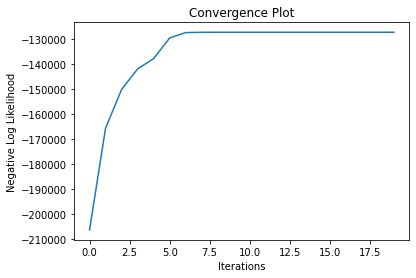

In [28]:
plt.title("Convergence Plot")
plt.xlabel("Iterations")
plt.ylabel("Negative Log Likelihood")
plt.plot(LLm*(-1))

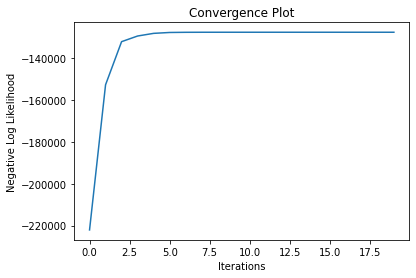

In [29]:
plt.title("Convergence Plot")
plt.xlabel("Iterations")
plt.ylabel("Negative Log Likelihood")
plt.plot(LLs*(-1))

## Negative likelihood is increasing in both as expected, meaning the model is converging

## TESTING

In [30]:
names_test = os.listdir('speech_music_classification/test/')

test_data = []

for name in names_test:
    test_data.append(spectrogram('speech_music_classification/test/'+name))

test_data = np.array(test_data)

test_data = test_data.reshape(test_data.shape[0], test_data.shape[2], test_data.shape[1])

In [31]:
LLM = []
LLS = []

for data in test_data:
    d = data[::3]
    seq = kmeans_whole.predict(d)
    tfm, scm = forward(seq,Am,Bm,pim)
    tfs, scs = forward(seq,As,Bs,pis)
    lm = np.log(scm)
    ls = np.log(scs)
    LLM.append(np.sum(lm))
    LLS.append(np.sum(ls))

In [33]:
assignment = []

for i in range(len(LLM)):
    if(LLM[i]>LLS[i]):
        assignment.append(1)
    elif(LLM[i]<LLS[i]):
        assignment.append(0)
        
assignment = np.array(assignment)

In [34]:
music_count = np.ones(24) # Music: 1
speech_count = np.zeros(24) # Speech: 0

real = np.concatenate((music_count,speech_count), axis=0)  # Real assignment from the test folder

In [1]:
# ## FINDING ACCURACY
# print("ACCURACY = ", (np.sum(real==assignment)/(len(real))*100), "%")